# Pricing : excess of rain cover

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import xarray as xr
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt
import math

%reload_ext autoreload
%autoreload 2

# Context

A client is looking to be covered against excess of rain.

You will first manipulate rasters and then use historical data to understand the risk.

# 1. Parameters

In [2]:
DATA_PATH = Path("C:/Users/channa/Downloads/data-scientist-technical-test-main/data-scientist-technical-test-main/data")
RASTERS_PATH = DATA_PATH / "rasters"

# 2. Data

## 2.1 Load data

In [3]:
vegetation_path = RASTERS_PATH / "vegetation.nc"
precipitation_path = RASTERS_PATH / "precipitation.nc"

In [4]:
vegetation_xr = xr.load_dataset(vegetation_path)
precipitation_xr = xr.load_dataset(precipitation_path)
precipitation_xr
vegetation_xr

<xarray.Dataset>
Dimensions:      (latitude: 20, longitude: 20)
Coordinates:
  * latitude     (latitude) float64 -4.756e+06 -4.756e+06 ... -4.761e+06
  * longitude    (longitude) float64 1.275e+06 1.276e+06 ... 1.28e+06 1.28e+06
    spatial_ref  int64 0
Data variables:
    vegetation   (latitude, longitude) float64 100.0 120.0 120.0 ... 110.0 110.0

In [5]:
# Display basic information about the precipitation dataset
print("Precipitation Dataset:")
print("Dimensions:", precipitation_xr.dims)
print("Coordinates:", precipitation_xr.coords)
print("Variables:", precipitation_xr.data_vars)
print("Attributes:", precipitation_xr.attrs)
print()

# Display basic information about the vegetation dataset
print("Vegetation Dataset:")
print("Dimensions:", vegetation_xr.dims)
print("Coordinates:", vegetation_xr.coords)
print("Variables:", vegetation_xr.data_vars)
print("Attributes:", vegetation_xr.attrs)

Precipitation Dataset:
Dimensions: Frozen({'longitude': 48, 'latitude': 48, 'time': 26433})
Coordinates: Coordinates:
    spatial_ref  int64 0
  * longitude    (longitude) float64 1.275e+06 1.276e+06 ... 1.28e+06 1.28e+06
  * latitude     (latitude) float64 -4.756e+06 -4.756e+06 ... -4.76e+06
  * time         (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2022-05-15
Variables: Data variables:
    precipitation  (latitude, longitude, time) float32 0.0 0.0 0.0 ... 0.0 0.0
Attributes: {}

Vegetation Dataset:
Dimensions: Frozen({'latitude': 20, 'longitude': 20})
Coordinates: Coordinates:
  * latitude     (latitude) float64 -4.756e+06 -4.756e+06 ... -4.761e+06
  * longitude    (longitude) float64 1.275e+06 1.276e+06 ... 1.28e+06 1.28e+06
    spatial_ref  int64 0
Variables: Data variables:
    vegetation  (latitude, longitude) float64 100.0 120.0 120.0 ... 110.0 110.0
Attributes: {}


## 2.2 Visualize data

Let's look at the coordinates values:

In [6]:
print(vegetation_xr.latitude.values[:2])

[-4755784.4062485 -4756034.4062485]


The coordinate reference system (crs) here is named an equal-area crs which means that the areas are preserved when projecting the earth to a plane. The unit of the coordinates is **meters**. See more info [there](https://en.wikipedia.org/wiki/Spatial_reference_system).

In [7]:
precipitation_xr

<xarray.Dataset>
Dimensions:        (longitude: 48, latitude: 48, time: 26433)
Coordinates:
    spatial_ref    int64 0
  * longitude      (longitude) float64 1.275e+06 1.276e+06 ... 1.28e+06 1.28e+06
  * latitude       (latitude) float64 -4.756e+06 -4.756e+06 ... -4.76e+06
  * time           (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2022-05-15
Data variables:
    precipitation  (latitude, longitude, time) float32 0.0 0.0 0.0 ... 0.0 0.0

One can notice that the precipitation raster has time variable. We then have access of cumulative daily precipitation data since the 1st of January 1950

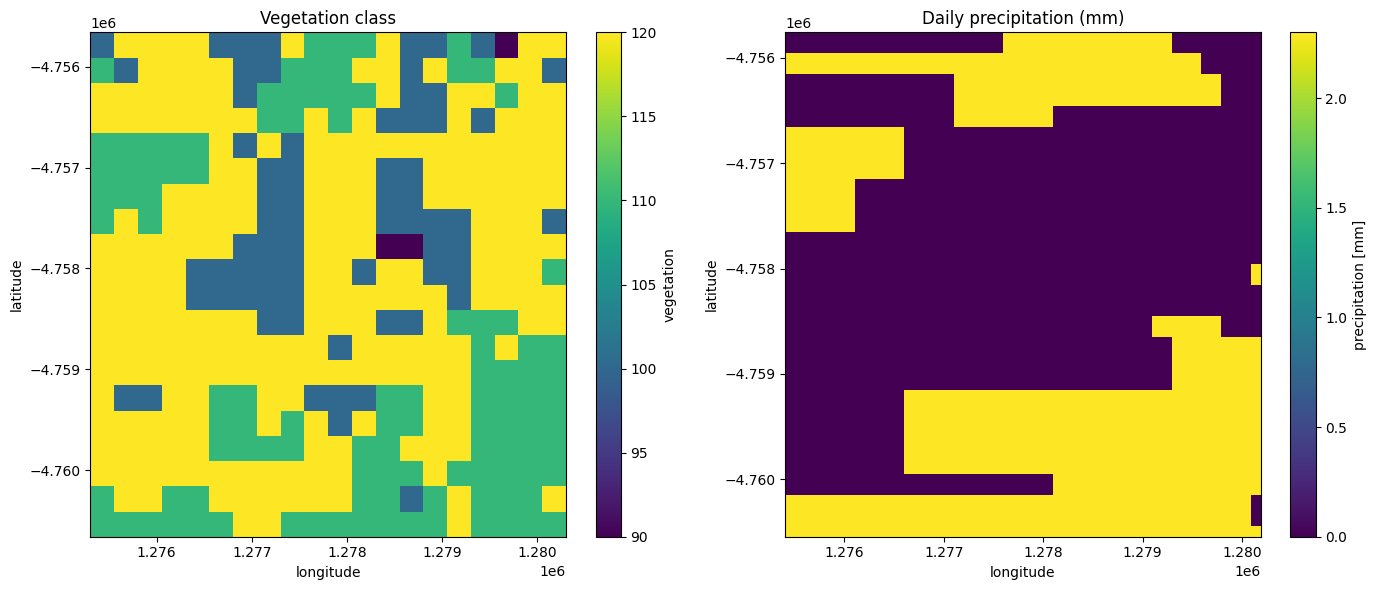

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
vegetation_xr.vegetation.plot(ax=ax[0])
ax[0].set_title("Vegetation class")
precipitation_xr.precipitation[dict(time=3)].plot(ax=ax[1])
ax[1].set_title("Daily precipitation (mm)")
ax[1].set_xlabel("longitude")
ax[1].set_ylabel("latitude")
plt.tight_layout()
plt.show()

The vegetation raster is a gridded array of categorical values with information on the type of the dominant vegetation of each pixel.

    - Class 90 : Water and urban areas
    - Class 100: Herbaceous class
    - Class 110: Forest class
    - Class 120: Shrubland class
    
For example, the pixel at location (longitude 1277929.24, latitude -4758284.41) displays a value of 120, meaning that the vegetation at this location is shrubland.

#### What is each raster's resolution (in meters)?

The resolution is defined as the distance between the centres of 2 neighbour pixels.

In [9]:
# NOTE: fill me!

#### Vegetation ####
# Calculate the number of longitude and latitude points in the 'vegetation_xr' dataset.
num_longitude_points = len(vegetation_xr.longitude)
num_latitude_points = len(vegetation_xr.latitude)

# Calculate the total number of pixels in the vegetation dataset.
num_pixels = num_longitude_points * num_latitude_points

# Calculate the range of latitude and longitude values in the vegetation dataset.
dist_lat = float(max(vegetation_xr.latitude)) - float(min(vegetation_xr.latitude))
dist_long = float(max(vegetation_xr.longitude)) - float(min(vegetation_xr.longitude))

#### Precipitation ####
# Calculate the number of longitude and latitude points in the 'precipitation_xr' dataset.
num_longitude_points_pr = len(precipitation_xr.longitude)
num_latitude_points_pr = len(precipitation_xr.latitude)

# Calculate the total number of pixels in the precipitation dataset.
num_pixels_pr = num_longitude_points_pr * num_latitude_points_pr

# Calculate the range of latitude and longitude values in the precipitation dataset.
dist_lat_pr = float(max(precipitation_xr.latitude)) - float(min(precipitation_xr.latitude))
dist_long_pr = float(max(precipitation_xr.longitude)) - float(min(precipitation_xr.longitude))

# Calculate the resolution of vegetation and precipitation data in terms of longitude.
vegetation_resolution = int(dist_long / num_longitude_points)
precipitation_resolution = int(dist_long_pr / num_longitude_points_pr)

# Print the calculated resolutions for vegetation and precipitation.
print("Vegetation Resolution:", vegetation_resolution)
print("Precipitation Resolution:", precipitation_resolution)


Vegetation Resolution: 237
Precipitation Resolution: 97


In [10]:
assert isinstance(vegetation_resolution, int)
assert isinstance(precipitation_resolution, int)

# 3. Manipulate rasters

### 3.1 Change rasters' resolution

Your task is to get the precipitation for all grid cells in the forest class (value of 110). Unfortunately, the 2 rasters do not have the same resolution. Your task will be to reindex the 2 rasters at the **same** resolution.

The resolution of each raster should be the finest one out of the 2 intial datasets.

To downscale (move from coarse to finer resolution), you will use the function `xarray.interp()`: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp.html

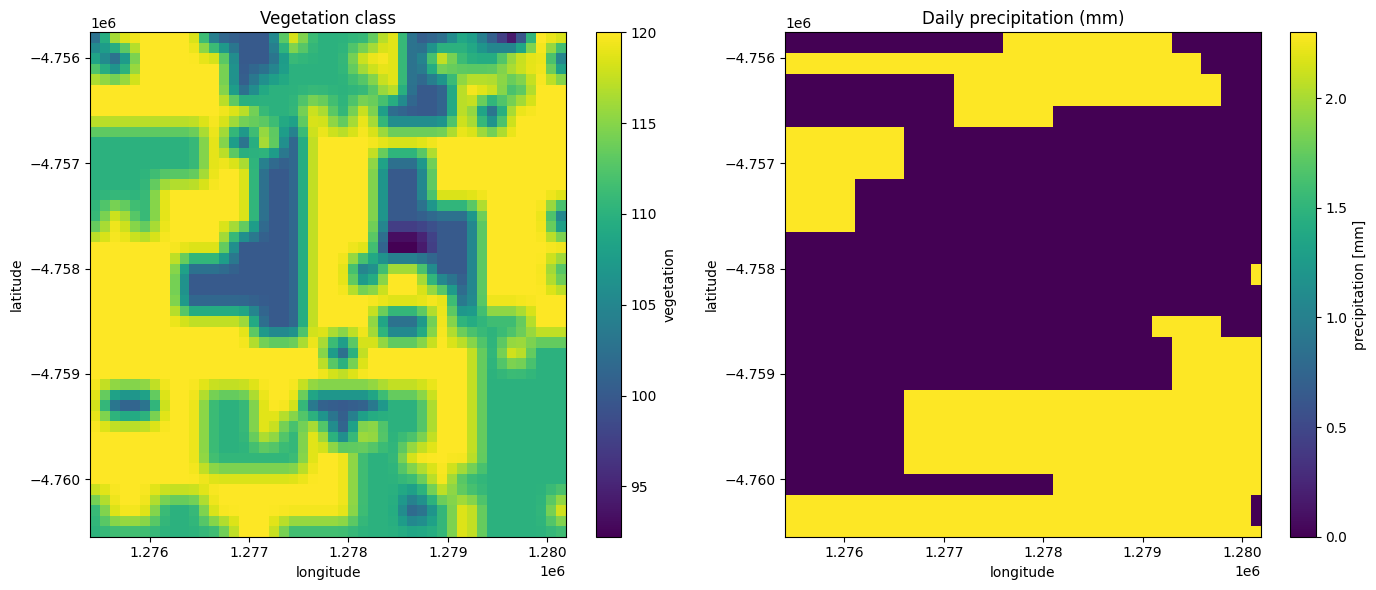

Precipitation Dataset:
Dimensions: Frozen({'longitude': 48, 'latitude': 48, 'time': 26433})
Vegetation Dataset:
Dimensions: Frozen({'latitude': 48, 'longitude': 48})


In [11]:
# NOTE: fill me!

# Extract longitude and latitude values from the 'precipitation_xr' dataset.
new_longitude = precipitation_xr.longitude.values
new_latitude = precipitation_xr.latitude.values

# Interpolate precipitation data using the extracted longitude and latitude values.
interpolated_vegetation = vegetation_xr.interp(
    longitude=new_longitude,
    latitude=new_latitude,
    method='linear'
)


# Create a subplot with two plots for visualization.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Assign the interpolated vegetation data to the downscaled vegetation dataset.
vegetation_downscaled_xr = interpolated_vegetation

# Assign the original precipitation data to the downscaled precipitation dataset.
precipitation_downscaled_xr = precipitation_xr

# Plot the downscaled vegetation data on the first subplot.
vegetation_downscaled_xr.vegetation.plot(ax=ax[0])
ax[0].set_title("Vegetation class")

# Plot a specific time slice of downscaled precipitation data on the second subplot.
precipitation_downscaled_xr.precipitation[dict(time=3)].plot(ax=ax[1])
ax[1].set_title("Daily precipitation (mm)")
ax[1].set_xlabel("longitude")
ax[1].set_ylabel("latitude")

# Adjust layout and display the plots.
plt.tight_layout()
plt.show()


# Display basic information about the precipitation dataset downscaled
print("Precipitation Dataset:")
print("Dimensions:", precipitation_downscaled_xr.dims)


# Display basic information about the vegetation dataset downscaled
print("Vegetation Dataset:")
print("Dimensions:", vegetation_downscaled_xr.dims)


In [12]:
assert isinstance(vegetation_downscaled_xr, xr.Dataset)
assert isinstance(precipitation_downscaled_xr, xr.Dataset)

## 3.2 Compute mean precipitation

The client has forests that span over all the area showed by the raster, which means that all grid cells in forest class belong to the client.

**Task**

Your task is to compute the mean daily precipitation for grid cells only in **forest class**. You may want to use the function [`xarray.where()`](https://docs.xarray.dev/en/stable/generated/xarray.where.html).

The output will be a dataframe `df_rain_historical` with the dates as index with name `Date` and the column daily precipitation renamed `daily_rain`. You could use the function [`xarray.to_dataframe()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.to_dataframe.html)

In [13]:
# NOTE: fill me!


# Define the target vegetation value to search for.
target_vegetation_value = 120.0

# Select coordinates where the vegetation value equals the target value.
matching_coords = vegetation_downscaled_xr.where(vegetation_downscaled_xr.vegetation == target_vegetation_value, drop=True)

# Calculate the mean precipitation per date for the coordinates where vegetation is equal to 120.
daily_precipitation_mean = precipitation_downscaled_xr['precipitation'].sel(latitude=matching_coords.latitude, longitude=matching_coords.longitude).mean(dim=['latitude', 'longitude'])

# Convert the result into a DataFrame.
df_rain_historical = daily_precipitation_mean.to_dataframe(name='daily_rain')

# Rename the index as 'Date'.
df_rain_historical.index.name = 'Date'

# Drop the 'spatial_ref' column if it exists.
df_rain_historical = df_rain_historical.drop(columns=['spatial_ref'])

# Print the resulting DataFrame.
print(df_rain_historical)



            daily_rain
Date                  
1950-01-01    0.000000
1950-01-02    0.000000
1950-01-03    2.289302
1950-01-04    0.892456
1950-01-05    0.000000
...                ...
2022-05-11    7.799149
2022-05-12    2.793769
2022-05-13    9.622956
2022-05-14    0.000000
2022-05-15    0.000000

[26433 rows x 1 columns]


In [14]:
assert df_rain_historical.index.name == "Date"

## 3.3 Next steps

The previous task helped you to compute the daily precipitation for one day at the client's locations. We actually have access to 70 years of historical data and that's the object of the next steps. The data from the previous part has been extracted at the client location into a dataframe that you will use from now on

# 4. Pricing

## 4.1 Context

The client is looking to be covered against excess of rain.

The client wishes to receive a payout under the following conditions:
+ Depends on the cumulative rainfall (mm) over the season.
+ Linear payout starting at a deductible of 650 mm and limit of 750 mm with a payout of AUD 500,000.

It means that 
+ If the cumulative rainfall is below 650 mm, the client receives nothing.
+ If the cumulative rainfall is above 750 mm, the client receives the max payout of AUD 500,000 no matter the loss.
+ If the cumulative rainfall is between 650 and 750 mm, the payout is linear, slope of AUD 5,000 per mm. For example, if the cumulative rainfall is 700 mm, the payout would be AUD 250,000.


## 4.2 Data

We have access to the cumulative rainfall (in millimeters-mm) each day since 1950 January 1st using the task before.

## 4.3 Preprocessing

### 4.3.1 Filtering

**Risk period**

The client would like to be covered from the 1st of December of a given year until 1st of March of the following year (**not included**).

**Task**
- Filter the historical dates to keep only the ones in the risk periods. ⚠️ You should not have incomplete seasons. ⚠️
- Remove the rows with the date equal to February 29th.
- Create a `season` column, the value of the season is the year corresponding to the 1st of December. For example, for the given risk period 1st of December 2021 - 1st of March 2022, the season is 2021.

In [15]:
# Print the historical daily precipitation DataFrame for months December, January, and February.
print(df_rain_historical[df_rain_historical.index.month.isin([12, 1, 2])])

            daily_rain
Date                  
1950-01-01    0.000000
1950-01-02    0.000000
1950-01-03    2.289302
1950-01-04    0.892456
1950-01-05    0.000000
...                ...
2022-02-24    0.000000
2022-02-25    0.620828
2022-02-26    0.000000
2022-02-27    1.358073
2022-02-28    0.000000

[6557 rows x 1 columns]


In [16]:
# NOTE: fill me!


# Filter the historical daily precipitation DataFrame for the period from December 1st to February 28th.
df_rain_historical = df_rain_historical[df_rain_historical.index.month.isin([12, 1, 2])]

# Remove rows where "Date" is equal to February 29
df_rain_historical = df_rain_historical[~((df_rain_historical.index.month == 2) & (df_rain_historical.index.day == 29))]


# Create a list of all years from 1950 to 2022.
years = range(1950, 2023)

# Initialize an empty list to store complete periods.
complete_periods = []

# Check if all reference periods exist in the data.
for year in years:
    reference_periods = pd.date_range(start=f'{year}-12-01', end=f'{year+1}-02-28', freq='D')
    if all(date in df_rain_historical.index for date in reference_periods):
        complete_periods.extend(reference_periods)

# Filter the data to retain only the complete periods.
df_rain_historical = df_rain_historical.loc[complete_periods]

# Add a 'season' column to the DataFrame and initialize it to None.
df_rain_historical['season'] = None

# Iterate through the rows of the DataFrame.
for index, row in df_rain_historical.iterrows():
    year = index.year  # Get the year of the index date
    if index.month < 12:  # Adjust the year for dates before December
        year -= 1
    df_rain_historical.at[index, 'season'] = year



# Print the modified historical daily precipitation DataFrame.
print(df_rain_historical)



            daily_rain season
Date                         
1950-12-01    0.038802   1950
1950-12-02    0.038802   1950
1950-12-03    0.077603   1950
1950-12-04    0.077603   1950
1950-12-05    6.518699   1950
...                ...    ...
2022-02-24    0.000000   2021
2022-02-25    0.620828   2021
2022-02-26    0.000000   2021
2022-02-27    1.358073   2021
2022-02-28    0.000000   2021

[6480 rows x 2 columns]


In [17]:
assert list(df_rain_historical.columns) == ["daily_rain", "season"]

### 4.3.2 Regroup by season

**Task**

- Create a new dataframe `df_cum_rain` by regrouping by season and by computing the cumulative rainfall over the risk period.
- Rename the column `daily_rain` by `cum_rain`.

In [18]:
# NOTE: fill me!

# Group the historical daily precipitation data by 'season' and calculate cumulative rainfall.
df_cum_rain = df_rain_historical.groupby('season')['daily_rain'].cumsum()

# Rename the 'daily_rain' column to 'cum_rain'.
df_cum_rain.rename('cum_rain', inplace=True)

# Create a new DataFrame by combining 'season' and 'cum_rain' columns.
df_cum_rain = pd.concat([df_rain_historical['season'], df_cum_rain], axis=1)

# Print the new DataFrame containing 'season' and cumulative rainfall.
print(df_cum_rain)


           season   cum_rain
Date                        
1950-12-01   1950   0.038802
1950-12-02   1950   0.077603
1950-12-03   1950   0.155207
1950-12-04   1950   0.232810
1950-12-05   1950   6.751509
...           ...        ...
2022-02-24   2021  56.263046
2022-02-25   2021  56.883873
2022-02-26   2021  56.883873
2022-02-27   2021  58.241947
2022-02-28   2021  58.241947

[6480 rows x 2 columns]


## 4.4 Compute payouts

Using the current values of `cum_rain`, we will now compute the historical payouts.

**Task**
- Design a function that computes the payouts using the structure defined above.
- Compute historical payouts since 1950 by creating a new dataframe `df_historical_payouts` with column `hist_payouts`. 

The resulting mean value of historical payouts is called **burning cost** and corresponds to the mean payout the client would have received based on the historica data. This is an important metrics in the design of insurance covers.

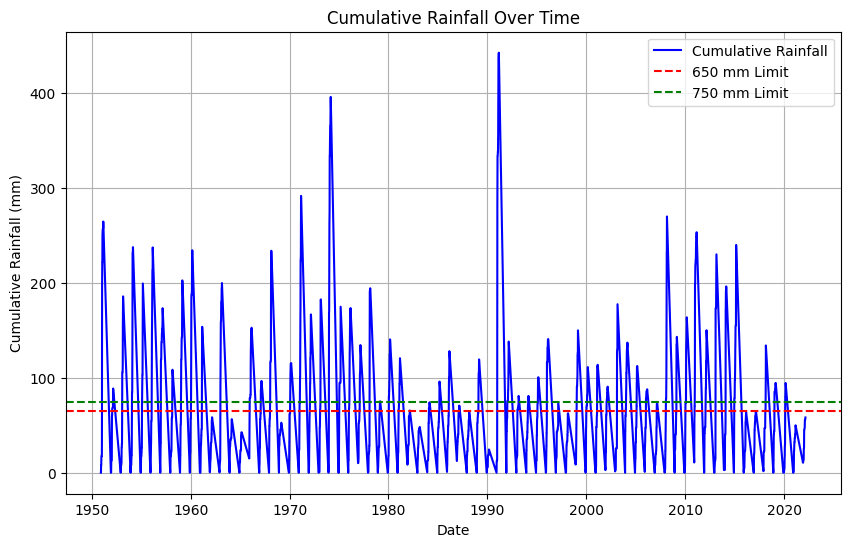

           season   cum_rain  Payout
Date                                
1950-12-01   1950   0.038802       0
1950-12-02   1950   0.077603       0
1950-12-03   1950   0.155207       0
1950-12-04   1950   0.232810       0
1950-12-05   1950   6.751509       0
...           ...        ...     ...
2022-02-24   2021  56.263046       0
2022-02-25   2021  56.883873       0
2022-02-26   2021  56.883873       0
2022-02-27   2021  58.241947       0
2022-02-28   2021  58.241947       0

[6480 rows x 3 columns]
        Payout
season        
1950    500000
1951    500000
1952    500000
1953    500000
1954    500000
...        ...
2017    500000
2018    500000
2019    500000
2020         0
2021         0

[72 rows x 1 columns]
Average Payout per Season: 384444.44444444444


In [19]:
# NOTE: fill me!


# Plot the cumulative rainfall over time
plt.figure(figsize=(10, 6))
plt.plot(df_cum_rain.index, df_cum_rain['cum_rain'], label='Cumulative Rainfall', color='blue')
plt.axhline(y=65, color='red', linestyle='--', label='650 mm Limit')
plt.axhline(y=75, color='green', linestyle='--', label='750 mm Limit')
plt.xlabel('Date')
plt.ylabel('Cumulative Rainfall (mm)')
plt.title('Cumulative Rainfall Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the payout based on cumulative rainfall
df_cum_rain['Payout'] = 0  # Initialize the 'Payout' column with zeros

# Define the conditions for payouts
condition_1 = df_cum_rain['cum_rain'] >= 75
condition_2 = (df_cum_rain['cum_rain'] >= 65) & (df_cum_rain['cum_rain'] < 75)

# Apply the conditions and calculate payouts
df_cum_rain.loc[condition_1, 'Payout'] = 500000
df_cum_rain.loc[condition_2, 'Payout'] = round((df_cum_rain['cum_rain'] - 65)) * 5000

# Print the updated DataFrame with payout information
print(df_cum_rain)

# Group by 'season' and calculate the maximum payout for each season
max_payout_per_season = df_cum_rain.groupby('season')['Payout'].max()
max_payout_per_season = pd.DataFrame(max_payout_per_season)

# Print the DataFrame containing the maximum payout for each season
print(max_payout_per_season)

# Calculate the average  payout per season
average_max_payout = max_payout_per_season['Payout'].mean()

# Print the average  payout per season
print("Average Payout per Season:", average_max_payout)



## 4.5 Weighting

### 4.5.1 Year type

We actually have access to historical yearly forecasts that states if the year was supposed to be rainy or not. There are 3 predictions:
- neutral
- dry
- rainy

All the information is stored in the dataframe `df_year_type`.

We will use this information to compute a weighted payouts using next year forecast.

In [20]:
year_type_data_path = DATA_PATH / "pricing" / "year_type_historical.csv"

In [21]:
df_year_type = (
    pd.read_csv(year_type_data_path, index_col=0)
    .rename(columns={"Year": "season"})
    .set_index("season")
)
df_year_type.head()

,year_type
season,
1950,rainy
1951,dry
1952,neutral
1953,dry
1954,rainy


**Task**

Do the same computation (historical payouts) for each of the year type (rainy, dry or neutral). Compute the burning cost of each of the year type. What can you observe ?

In [22]:
# NOTE: fill me!

# Perform a left join between max_payout_per_season and df_year_type on 'season'
merged_df = max_payout_per_season.merge(df_year_type, on='season', how='left')

# Print the merged DataFrame
print(merged_df)

# Group the merged DataFrame by 'year_type' and calculate the average payout for each year type
average_payout_by_year_type = merged_df.groupby('year_type')['Payout'].mean()

# Print the average payout for each year type
print(average_payout_by_year_type)


        Payout year_type
season                  
1950    500000     rainy
1951    500000       dry
1952    500000   neutral
1953    500000       dry
1954    500000     rainy
...        ...       ...
2017    500000     rainy
2018    500000       dry
2019    500000       dry
2020         0     rainy
2021         0     rainy

[72 rows x 2 columns]
year_type
dry        349230.769231
neutral    395000.000000
rainy      410925.925926
Name: Payout, dtype: float64


### 4.5.2 Next year forecast

The forecast for next year is given in terms of probability for each of the year types:

In [23]:
next_year_forecast = {"dry": 0.58, "neutral": 0.37, "rainy": 0.05}

**Task**

How would you leverage on these forecasts to better estimate the risk and adjust the burning cost ? 

In [24]:
# NOTE: fill me!

# Given vector of forecast probabilities for the next year
next_year_forecast = {"dry": 0.58, "neutral": 0.37, "rainy": 0.05}

# Calculate the adjusted burning cost based on the forecasted probabilities
burning_cost_adjusted = (
    next_year_forecast["dry"] * average_payout_by_year_type["dry"] +
    next_year_forecast["neutral"] * average_payout_by_year_type["neutral"] +
    next_year_forecast["rainy"] * average_payout_by_year_type["rainy"]
)

# Print the adjusted burning cost
print(burning_cost_adjusted)



369250.1424501424


---
# END OF SCRIPT